### Pressure and Waist profile

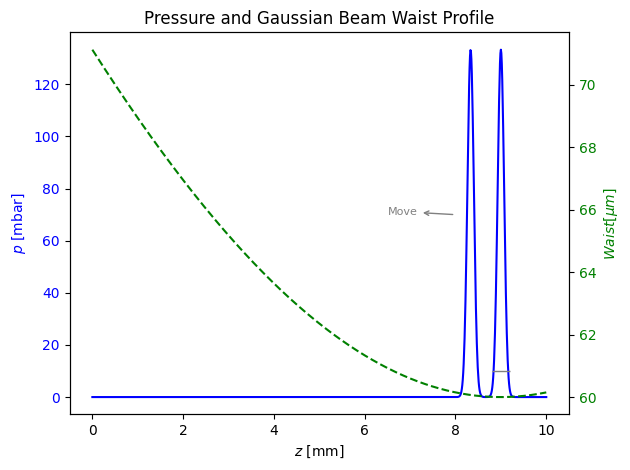

The average pressure is $\bar{p}=4.73~{\mathrm{mbar}}$ (this value will be used as the reference for the CUPRAD propagation).

### Pressure and Waist profile

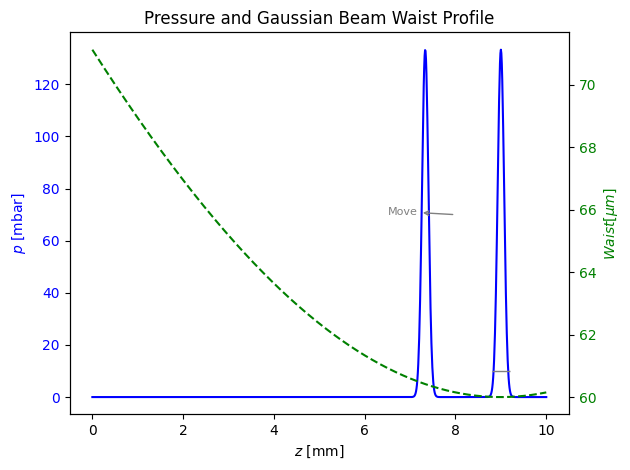

The average pressure is $\bar{p}=4.73~{\mathrm{mbar}}$ (this value will be used as the reference for the CUPRAD propagation).

### Properties of the chosen discretisation (CUPRAD)
* The chosen discretisation in time gives ~ 51
points per one laser period.
* The stepsize in the radial discretisation is ~ $0.28
~\mu {\mathrm{m}}$.
* The size of the radial computational box is ~ $240.00
~\mu {\mathrm{m}}$. The maximal radius of the reference Gaussian beam is ~ $71.13
~\mu {\mathrm{m}}$.$^\dagger$ 

$^\dagger$ This is given at the $z$-edges of the copmutational box.


### Physical consequences of the chosen numerical parameters (TDSE)
* The step-size in $z$ is derived from the CUPRAD's adaptive steps, the stride for CTDSE is 1. (Generally, we do not recommend to use stride > 1.$^\dagger$)
* The macroscopic radial discretisation for TDSE is $2.78
~\mu {\mathrm{m}}$; the macroscopic radial boxsize is $r_{\text{max}}=55.57
~\mu {\mathrm{m}}$.
* The outputs stored from CTDSE runs are: ***electric field***, ***<dj/dt> (Fourier)***, ***ground-state population (projected)***, ***<x>***.
* Possible ouputs *ground-state population (projected)* and *ground-state population (integrated)* refer to various approaches to ionisation. See
[link 1](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.106.053115) or [link 2](https://theses.hal.science/tel-04192431v1/document)$^{\dagger\dagger}$ (Chapter 3) for details.
* The microscopic computatinal box for 1D-TDSE is $x_{\text{max}} = 6400~{\mathrm{a.u.}}~(338.67~{\mathrm{nm}})$.
* The maximal energy in the spectrum according to the chosen discretisation is $E_{\text{max}} = 683.90~{\mathrm{eV}}$ ($H_{\text{max}} \sim 441$).
* Theoretical maximal distances of a classical electron ejected at the peak of the pulse reached at,
respectively, the end of the compuational box and the trailing edge of the pulse ($1/\mathrm{e}^2$ of the intensity).$^{\dagger\dagger\dagger}$
    * [Direct electrons with $E_{\text{kin}} \sim 5U_p$](https://doi.org/10.1103/PhysRevA.106.053115) $s_{\text{max}} = 1621.48~{\mathrm{a.u.}}~(85.80~{\mathrm{nm}})$.
    * [Rescatterred electrons $E_{\text{kin}} \sim 10U_p$](https://doi.org/10.1038/nphys914) $s_{\text{max}} = 2293.11~{\mathrm{a.u.}}~(121.35~{\mathrm{nm}})$, $s_{\text{max,2}} = 191.09~{\mathrm{a.u.}}~(10.11~{\mathrm{nm}})$.
* The cut-off for the peak on-axis entry intensity is $H_{\text{cut-off}} = 61.72$ (given by $I_P + 3.17 U_p$).


$^\dagger$ The step-size in $z$ is usually adapted such that the variations of the phase are affecting XUV when using a coarser grid. \
$^{\dagger\dagger}$ *ground-state population (projected)* corresponds to Eq. (3.20) and *ground-state population (projected)* to Eq. (3.1) of [link 2](https://theses.hal.science/tel-04192431v1/document). \
$^{\dagger\dagger\dagger}$ This is computed from the theoretical peak intensity. Especially for high intensities, [it might be fastly clamped and the effective peak intensity is lower](https://doi.org/10.1007/s003400100637).


### The role of parameters of the camera and the integration (Hankel)
* The macroscopic radial discretisation for Hankel integral is $2.78
~\mu {\mathrm{m}}$; the macroscopic radial boxsize is $r_{\text{max, integration}}=652.92
~\mu {\mathrm{m}}$.
* The camera size, $r_{\text{max, camera}}=7.00
~{\mathrm{mm}}$, gives the maximal divergeic radial discretisation for TDSE is ; the macroscopic radial boxsize is nce recorded by the XUV is $\theta_{\text{max, camera}}=7.00
~{\mathrm{mrad}}$. (See the initial section with the physical parameters.)
* The diffraction limit for the maximal expected cut-off provided by the discretisation in the integral is  $r_{\text{max, camera, cut-off}}=4.66
~{\mathrm{mm}}$ (corresponding divergence $\theta_{\text{max, camera, cut-off}}=4.66
~{\mathrm{mrad}}$)


In [96]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import os
import shutil
import h5py
import sys
import MMA_administration as MMA
import mynumerics as mn
import units
import HHG
from IPython.display import display, Markdown


%matplotlib inline
# import mpld3
# mpld3.enable_notebook()


for para in range(1 , 2+1):
    h5path = os.path.join(os.environ['MULTISCALE_WORK_DIR'],'loop_inputs',f'send{para}')
    h5file = os.path.join(h5path,f'parameter_10mm_{para}.h5')
    
    
    # gas specifiers
    gas = 'Ar'
    medium_length = 10e-3 # [m]10e-3
    ionisation_model = 'PPT'
    XUV_dispersion_tables = 'NIST'
    XUV_absorption_tables = 'Henke'
    
    laser_wavelength = 800e-9         # [m]
    reference_Gaussian_focus = (9/10) * medium_length # [m]
    reference_Gaussian_waist = 60e-6 # [m]
    reference_Gaussian_focus_intensity  = 5e18 # [W/m2]
    laser_pulse_duration = 9e-15 # [s] (defined via 1/e in the electric field amplitude)
    # density profile (Here you can define whatever density profile you want by the function `pressure_profile(z)`.)
    peak_pressure = 133.3e-3   #50e-3
    relative_jet_size = 1./(medium_length*1e4)   #1/100
    
    #def pressure_profile(z):
    #    return peak_pressure*np.exp(-((z-0.5*medium_length)/(relative_jet_size*medium_length))**2)
    
    def pressure_profile(z):
        return peak_pressure * np.exp(-((z - reference_Gaussian_focus) / (relative_jet_size * medium_length))**2) \
              +peak_pressure * np.exp(-((z - ((14/15) * medium_length  -0.001*para    )) / (relative_jet_size * medium_length))**2)\
              #+0.001
    def gaussian_beam_waist(z, waist0, wl):
        zr = np.pi * waist0**2 / wl
        wz = waist0 * np.sqrt(1 + ((z - reference_Gaussian_focus) / zr)**2)
        return wz
        
    dz_pressure = 1e-5
    zgrid_pressure = np.ogrid[0:(medium_length+dz_pressure):dz_pressure]
    average_pressure = integrate.simpson(pressure_profile(zgrid_pressure),zgrid_pressure)/medium_length
    pressure_modulation = pressure_profile(zgrid_pressure)/average_pressure
    
    
    
    
    
    ### Code to generate the figure and the following text:
    display(Markdown(rf"""### Pressure and Waist profile"""))
    # fig = plt.figure()
    # plt.plot(1e3*zgrid_pressure,1e3*average_pressure*pressure_modulation)same first dimension
    # plt.xlabel('$z$ [mm]'); plt.ylabel('$p$ [mbar]')
    # # plt.title('pressure profile in the gas')
    # plt.show()
    i_length=0.4 #mm
    fig, ax1 = plt.subplots()
    # 左 Y 轴：气体压力
    ax1.plot(1e3 * zgrid_pressure, 1e3 * average_pressure * pressure_modulation, 'b-', label='Pressure')
    ax1.set_xlabel('$z$ [mm]')
    ax1.set_ylabel('$p$ [mbar]', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.hlines(y=10, xmin= 1e3* medium_length*(9/10) - i_length/2, xmax=1e3*medium_length*(9/10) + i_length/2 , color='grey', linestyle='-', linewidth=1)
    # ax1.hlines(y=1, xmin= 1e3* medium_length/2 - 2*i_length, xmax=1e3*medium_length/2 + 2*i_length , color='red', linestyle='-', linewidth=1)
    
    ax1.annotate(
        'Move',color='grey',  fontsize=8,                       # 空标签（没有文字）
        xy=(reference_Gaussian_focus*1e3-1,70),                  # 箭头指向的位置
        xytext=(reference_Gaussian_focus*1e3-2.5, 70),            # 箭头起点
        arrowprops=dict(arrowstyle='<-', color='grey')
    )
    
    # ax1.annotate(
    #     'Interaction length \n        (400um)',color='grey',  fontsize=10,                       
    #     xy=(reference_Gaussian_focus-0.001,75),
    #     xytext=(reference_Gaussian_focus,70)
    # )
    # 右 Y 轴：激光束腰
    ax2 = ax1.twinx()
    ax2.plot(1e3 * zgrid_pressure, 1e6 * gaussian_beam_waist(zgrid_pressure, reference_Gaussian_waist, laser_wavelength), 'g--', label='Beam waist')
    ax2.set_ylabel(r'$Waist [\mu m]$', color='g')
    ax2.tick_params(axis='y', labelcolor='g')
    
    plt.title("Pressure and Gaussian Beam Waist Profile")
    plt.tight_layout()
    plt.show()
    
    display(Markdown(rf"""The average pressure is $\bar{{p}}={1e3*average_pressure:.2f}~{{\mathrm{{mbar}}}}$ (this value will be used as the reference for the CUPRAD propagation)."""))
    



    
    XUV_camera_distance         = 1. # [m] (from the entry of the cell)
    XUV_camera_harmonic_range   = np.asarray([10., 50.]) # [harmonic order]
    #print(XUV_camera_harmonic_range)
    XUV_camera_radial_range     = 0.007 # [m]
    number_of_points_in_r      = 1024
    number_of_points_in_t      = 2048
    operators_t                =	2
    first_delta_z     =	0.01 # [mm]
    phase_threshold_for_decreasing_delta_z = 0.002	# [rad]
    length_of_window_for_r_normalized_to_beamwaist = 4.   # [-]
    length_of_window_for_t_normalized_to_pulse_duration = 12. # [-]
    number_of_absorber_points_in_time = 16  # [-]
    physical_output_distance_for_plasma_and_Efield = 0.00001   # [m]
    output_distance_in_z_steps_for_fluence_and_power   = 100  # [-]
    radius_for_diagnostics = 0.1 # [cm]
    run_time_in_hours = 5.0 # [h] 
    
    
    # Macroscopic: to slect the grid based on the CUPRAD grid
    kz_step = 1
    kr_step_CTDSE = 10   #2
    Nr_max = 200        #400
    # Microscopic part
    dt_TDSE = 0.25 # [a.u.]
    dx      = 0.4  # [a.u.]
    Nx_max  = 16000 # (spans from -dx*Nx_max to dx*Nx_max)
    x_int   = 2.0  # [a.u.]
    CV_criterion_of_ground_state = 1e-12 # [-]
    # Outputs
    # choose from: 'electric field', 'electric field (Fourier),
    #              '<dj/dt>', '<dj/dt> (Fourier)'
    #              'ground-state population (projected)', 'ground-state population (integrated)'
    #              '<x>'
    list_of_CTDSE_outputs = ['electric field', '<dj/dt> (Fourier)',
                             'ground-state population (projected)', '<x>']
    
    store_cumulative_field = True
    kr_step_Hankel                   = 1
    ko_step                          = 2
    Nr_max_Hankel_integration        = 235
    XUV_camera_number_of_r_points    = 200
    Nthreads = 32
    
    # Code to create the input hdf5-file
    ## First, we prepare dictionaries between hdf5-inputs and this jupyter notebook
    
    global_input_names_to_jupyter_variables = {
        'gas_preset'                                : (np.bytes_(gas),                       '[-]'   ),
        'medium_pressure_in_bar'                    : (average_pressure,                      '[bar]' )
    }
    
    
    CUPRAD_names_to_jupyter_variables = {
        # laser parameters
        'laser_wavelength'                          : (1e2*laser_wavelength,                  '[cm]'  ),
        'laser_pulse_duration_in_1_e_Efield'        : (1e15*laser_pulse_duration,             '[fs]' ),
        'laser_focus_intensity_Gaussian'            : (reference_Gaussian_focus_intensity,    '[s]'  ),
        'laser_focus_beamwaist_Gaussian'            : (reference_Gaussian_waist,              '[m]'  ),
        'laser_focus_position_Gaussian'             : (reference_Gaussian_focus,              '[m]'  ),
    
        # medium parameters
        'medium_physical_distance_of_propagation'   : (medium_length,                         '[m]'   ),
    
        # ionisation
        'ionization_model'                          : (np.bytes_(ionisation_model),          '[s]'  ),
    
        # numerics
        'numerics_number_of_points_in_r'            : (number_of_points_in_r,                 '[-]'  ),
        'numerics_number_of_points_in_t'            : (number_of_points_in_t,                 '[-]'  ),
        'numerics_operators_t_t-1'                  : (operators_t,                           '[-]'  ),
        'numerics_physical_first_stepwidth'         : (first_delta_z,                         '[mm]' ),
        'numerics_phase_threshold_for_decreasing_delta_z' : 
            (phase_threshold_for_decreasing_delta_z,                '[rad]' ),
        'numerics_length_of_window_for_r_normalized_to_beamwaist':
            (length_of_window_for_r_normalized_to_beamwaist,        '[-]'   ),
        'numerics_length_of_window_for_t_normalized_to_pulse_duration' :
            (length_of_window_for_t_normalized_to_pulse_duration,   '[-]'   ),
        'numerics_number_of_absorber_points_in_time':
            (number_of_absorber_points_in_time ,                    '[-]'   ),
        'numerics_physical_output_distance_for_plasma_and_Efield' :
            (physical_output_distance_for_plasma_and_Efield,        '[m]'   ),
        'numerics_output_distance_in_z-steps_for_fluence_and_power' :
            (output_distance_in_z_steps_for_fluence_and_power,      '[-]'   ),
        'numerics_radius_for_diagnostics'           : (radius_for_diagnostics,                '[cm]' ),
        'numerics_run_time_in_hours'                : (run_time_in_hours,                     '[s]'  )
    }
    
    
    CTDSE_names_to_jupyter_variables = {
        # Physics
        'x_int'                                     : (x_int,                                 '[a.u.]' ),
    
        # Macro grid
        'Nr_max'                                    : (Nr_max,                                '[-]'    ),
        'kr_step'                                   : (kr_step_CTDSE,                               '[-]'    ),
        'kz_step'                                   : (kz_step,                               '[-]'    ),  
    
        # Microscopic numerics
        'dx'                                        : (dx,                                    '[a.u.]' ),
        'Nx_max'                                    : (Nx_max,                                '[a.u.]' ),
        'dt'                                        : (dt_TDSE,                               '[a.u.]' ),
    
        'CV_criterion_of_GS'                        : (CV_criterion_of_ground_state,          '[a.u.]')
    }
    
    
    CTDSE_outputs_to_jupyter_names = {
        'print_Efield'                : 'electric field',
        'print_F_Efield'              : 'electric field (Fourier)',
        'print_Source_Term'           : '<dj/dt>',
        'print_F_Source_Term'         : '<dj/dt> (Fourier)',
        'print_GS_population'         : 'ground-state population (projected)',
        'print_integrated_population' : 'ground-state population (integrated)',
        'print_x_expectation_value'   : '<x>'}
    
    Hankel_names_to_jupyter_variables = {
        'distance_FF'                               : (XUV_camera_distance,                   '[m]'  ),
        'rmax_FF'                                   : (XUV_camera_radial_range,               '[m]'  ),
        'Nr_FF'                                     : (XUV_camera_number_of_r_points,         '[-]'  ),
    
        'XUV_table_type_dispersion'                 : (np.bytes_(XUV_dispersion_tables),     '[-]'  ),
        'XUV_table_type_absorption'                 : (np.bytes_(XUV_absorption_tables),     '[-]'  ),
    
        'kr_step'                                   : (kr_step_Hankel,                               '[-]'  ),
        'ko_step'                                   : (ko_step,                               '[-]'  ),
        'Nr_max'                                    : (Nr_max_Hankel_integration,             '[-]'  ),
        'Harmonic_range'                            : (XUV_camera_harmonic_range,      '[harmonic order]'),
    
        'store_cumulative_result'                  : (int(store_cumulative_field),          '[-]'  ),   
        'Nthreads'                                  : (Nthreads,                              '[-]'  ) 
    }
    
    
    from inputs_transformer import add_variables2hdf5
    if os.path.exists(h5path): shutil.rmtree(h5path)  # clean the input directory if it existed
    os.makedirs(h5path)
    
    ## Create the hdf5-archive
    with h5py.File(h5file,'w') as f: 
    
        add_variables2hdf5(f,
                        global_input_names_to_jupyter_variables,
                        CUPRAD_names_to_jupyter_variables,
                        CTDSE_names_to_jupyter_variables,
                        CTDSE_outputs_to_jupyter_names,
                        list_of_CTDSE_outputs,
                        Hankel_names_to_jupyter_variables)
    
        global_inputs = f[MMA.paths['global_inputs']]
        density_modulation = global_inputs.create_group('density_mod')
        mn.adddataset(density_modulation ,'table',pressure_modulation,'[-]')
        mn.adddataset(density_modulation ,'zgrid',zgrid_pressure,'[m]')
    
    





## Code to generate the following text ##
## Code to generate the following text ##
zR = (np.pi*reference_Gaussian_waist**2)/laser_wavelength
dr_CUPRAD = length_of_window_for_r_normalized_to_beamwaist * reference_Gaussian_waist*np.sqrt(1+(reference_Gaussian_focus/zR)**2)/number_of_points_in_r
display(Markdown(rf"""### Properties of the chosen discretisation (CUPRAD)
* The chosen discretisation in time gives ~ {
            number_of_points_in_t/(
            laser_pulse_duration*length_of_window_for_t_normalized_to_pulse_duration/mn.ConvertPhoton(laser_wavelength,'lambdaSI','T0SI')
            )
    :.0f}
points per one laser period.
* The stepsize in the radial discretisation is ~ ${
      1e6*dr_CUPRAD
      :.2f}
~\mu {{\mathrm{{m}}}}$.
* The size of the radial computational box is ~ ${
      1e6*length_of_window_for_r_normalized_to_beamwaist * reference_Gaussian_waist
      :.2f}
~\mu {{\mathrm{{m}}}}$. The maximal radius of the reference Gaussian beam is ~ ${
      1e6*np.max([
            reference_Gaussian_waist*np.sqrt(1+((medium_length-reference_Gaussian_focus)/zR)**2),
            reference_Gaussian_waist*np.sqrt(1+(reference_Gaussian_focus/zR)**2)
            ])
      :.2f}
~\mu {{\mathrm{{m}}}}$.$^\dagger$ 

$^\dagger$ This is given at the $z$-edges of the copmutational box.
"""))



#reference_Gaussian_focus_intensity = peak_intensity
onax_entry_intensity = (reference_Gaussian_focus_intensity/units.INTENSITYau)/np.sqrt(1+(reference_Gaussian_focus/zR)**2)
onax_entry_ponderomotive_potential = onax_entry_intensity/(4.*mn.ConvertPhoton(laser_wavelength,'lambdaSI','omegaau'))
max_Ek_direct = 5.*onax_entry_ponderomotive_potential
max_electron_velocity_direct = np.sqrt(2.*max_Ek_direct)
max_Ek_rescattered = 10.*onax_entry_ponderomotive_potential
max_electron_velocity_rescattered = np.sqrt(2.*max_Ek_rescattered)
t_box = (length_of_window_for_t_normalized_to_pulse_duration*laser_pulse_duration)/units.TIMEau

display(Markdown(rf"""### Physical consequences of the chosen numerical parameters (TDSE)
* The step-size in $z$ is derived from the CUPRAD's adaptive steps, the stride for CTDSE is {kz_step}. (Generally, we do not recommend to use stride > 1.$^\dagger$)
* The macroscopic radial discretisation for TDSE is ${
      1e6*kr_step_CTDSE*dr_CUPRAD  
      :.2f}
~\mu {{\mathrm{{m}}}}$; the macroscopic radial boxsize is $r_{{\text{{max}}}}={
    1e6*Nr_max*dr_CUPRAD
    :.2f}
~\mu {{\mathrm{{m}}}}$.
* The outputs stored from CTDSE runs are: {', '.join(['***'+foo+'***' for foo in list_of_CTDSE_outputs])}.
* Possible ouputs *ground-state population (projected)* and *ground-state population (integrated)* refer to various approaches to ionisation. See
[link 1](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.106.053115) or [link 2](https://theses.hal.science/tel-04192431v1/document)$^{{\dagger\dagger}}$ (Chapter 3) for details.
* The microscopic computatinal box for 1D-TDSE is $x_{{\text{{max}}}} = {
    dx*Nx_max
    :.0f}~{{\mathrm{{a.u.}}}}~({
    1e9*dx*Nx_max * units.LENGTHau    
    :.2f}~{{\mathrm{{nm}}}})$.
* The maximal energy in the spectrum according to the chosen discretisation is $E_{{\text{{max}}}} = {
    mn.ConvertPhoton((2.*np.pi/dt_TDSE),'omegaau','eV')
    :.2f}~{{\mathrm{{eV}}}}$ ($H_{{\text{{max}}}} \sim {
    (2.*np.pi/dt_TDSE)/mn.ConvertPhoton(laser_wavelength,'lambdaSI','omegaau')
    :.0f}$).
* Theoretical maximal distances of a classical electron ejected at the peak of the pulse reached at,
respectively, the end of the compuational box and the trailing edge of the pulse ($1/\mathrm{{e}}^2$ of the intensity).$^{{\dagger\dagger\dagger}}$
    * [Direct electrons with $E_{{\text{{kin}}}} \sim 5U_p$](https://doi.org/10.1103/PhysRevA.106.053115) $s_{{\text{{max}}}} = {
    max_electron_velocity_direct*0.5*t_box
    :.2f}~{{\mathrm{{a.u.}}}}~({
    1e9*max_electron_velocity_direct*0.5*t_box*units.LENGTHau    
    :.2f}~{{\mathrm{{nm}}}})$.
    * [Rescatterred electrons $E_{{\text{{kin}}}} \sim 10U_p$](https://doi.org/10.1038/nphys914) $s_{{\text{{max}}}} = {
    max_electron_velocity_rescattered*0.5*t_box
    :.2f}~{{\mathrm{{a.u.}}}}~({
    1e9*max_electron_velocity_rescattered*0.5*t_box*units.LENGTHau    
    :.2f}~{{\mathrm{{nm}}}})$, $s_{{\text{{max,2}}}} = {
    max_electron_velocity_rescattered*0.5*(laser_pulse_duration/units.TIMEau)
    :.2f}~{{\mathrm{{a.u.}}}}~({
    1e9*max_electron_velocity_rescattered*0.5*(laser_pulse_duration/units.TIMEau)*units.LENGTHau    
    :.2f}~{{\mathrm{{nm}}}})$.
* The cut-off for the peak on-axis entry intensity is $H_{{\text{{cut-off}}}} = {
   HHG.ComputeCutoff_gas(onax_entry_intensity,mn.ConvertPhoton(laser_wavelength,'lambdaSI','omegaau'),gas=gas)[1]
    :.2f}$ (given by $I_P + 3.17 U_p$).


$^\dagger$ The step-size in $z$ is usually adapted such that the variations of the phase are affecting XUV when using a coarser grid. \
$^{{\dagger\dagger}}$ *ground-state population (projected)* corresponds to Eq. (3.20) and *ground-state population (projected)* to Eq. (3.1) of [link 2](https://theses.hal.science/tel-04192431v1/document). \
$^{{\dagger\dagger\dagger}}$ This is computed from the theoretical peak intensity. Especially for high intensities, [it might be fastly clamped and the effective peak intensity is lower](https://doi.org/10.1007/s003400100637).
"""))



## Code to generate the following text ##
dr_Hankel = kr_step_CTDSE*kr_step_Hankel*dr_CUPRAD


first_diffraction_maximum_cutoff = laser_wavelength/\
        (dr_Hankel*HHG.ComputeCutoff_gas(onax_entry_intensity,mn.ConvertPhoton(laser_wavelength,'lambdaSI','omegaau'),gas=gas)[1])

display(Markdown(rf"""### The role of parameters of the camera and the integration (Hankel)
* The macroscopic radial discretisation for Hankel integral is ${
      1e6*dr_Hankel   
      :.2f}
~\mu {{\mathrm{{m}}}}$; the macroscopic radial boxsize is $r_{{\text{{max, integration}}}}={
    1e6*Nr_max_Hankel_integration*dr_Hankel 
    :.2f}
~\mu {{\mathrm{{m}}}}$.
* The camera size, $r_{{\text{{max, camera}}}}={
    1e3*XUV_camera_radial_range/XUV_camera_distance
    :.2f}
~{{\mathrm{{mm}}}}$, gives the maximal divergeic radial discretisation for TDSE is ; the macroscopic radial boxsize is nce recorded by the XUV is $\theta_{{\text{{max, camera}}}}={
    1e3*np.arctan(XUV_camera_radial_range/XUV_camera_distance ) 
    :.2f}
~{{\mathrm{{mrad}}}}$. (See the initial section with the physical parameters.)
* The diffraction limit for the maximal expected cut-off provided by the discretisation in the integral is  $r_{{\text{{max, camera, cut-off}}}}={
    1e3*first_diffraction_maximum_cutoff
    :.2f}
~{{\mathrm{{mm}}}}$ (corresponding divergence $\theta_{{\text{{max, camera, cut-off}}}}={
    1e3*np.arctan(first_diffraction_maximum_cutoff/XUV_camera_distance ) 
    :.2f}
~{{\mathrm{{mrad}}}}$)
"""))

# print(laser_wavelength/(50.*dr_Hankel))